# Stock-Forecasting

Stock market can be seen as a sequence of values (each day could be a time step), and thus you can predict the closing value of the next day, knowing the past.

## Data exploration

First, we load the dataset `all_stocks_5yr.csv`, which contains all the stock market values over 5 years for many companies.

In [1]:
# TODO: Load the dataset and explore it
import pandas as pd
import seaborn as sns
import sklearn as sk
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# To ignore annoying warning
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
#Loading dataset and exploring
stocks_df = pd.read_csv('all_stocks_5yr.csv')
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [3]:
stocks_df['date']=pd.to_datetime(stocks_df['date'])
stocks_df.head(5)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


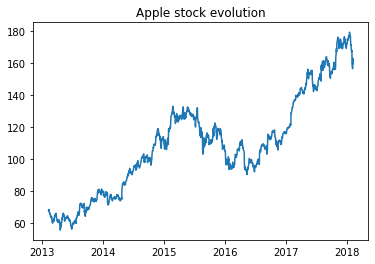

In [4]:
# Plot the stock market evolution of a Apple
Apple_df = stocks_df[stocks_df['Name'] =='AAPL']

plt.plot(Apple_df['date'],Apple_df['close'])
plt.title("Apple stock evolution")
plt.show()

In [5]:
### Select companies with enough data to create a sequential model

companies_to_analyse = []
companies_df = {}

for name in stocks_df['Name'].unique():
    company_df = stocks_df[stocks_df['Name'] == name]
    if len(company_df) > 1000 :
        companies_to_analyse.append(name)
        companies_df[name] = company_df

> NB: for those who want a more accurate representation of the stock market, a really common visualization is the candlesticks. One can plot them using the matplotlib finance library https://github.com/matplotlib/mplfinance

## Data preparation

We prepare data with a lookback of 30 days in order to predict close value based on `[open, high, low, close, volume]` of the past 30 days. We also rescale the data.

In [6]:
from sklearn.preprocessing import StandardScaler

def processData(data, past):
    X,Y = [],[]
    for i in range(len(data)-past):
        X.append(data[i:i+past, 0:5])
        Y.append(data[i+past, 3])

    return np.array(X),np.array(Y)

columns_to_shift = ['open', 'high', 'low', 'close', 'volume']
lookback = 30 #here in days

companies_scaled_data = {}
companies_processed_data = {}
companies_scaler = {}
companies_dates = {}

for name in companies_to_analyse :
    companies_processed_data[name] = {}
    
    data_company = companies_df[name][columns_to_shift]
    
    companies_dates[name] = companies_df[name]['date'].to_numpy()
    
    scaler = StandardScaler()
    data_scaled_company = scaler.fit_transform(data_company)
    companies_scaled_data[name] = data_scaled_company
    companies_scaler[name] = scaler
    
    X, y = processData(data_scaled_company, lookback)
    
    companies_processed_data[name]['X'] = X
    companies_processed_data[name]['y'] = y

# Train-Test splitting

In [7]:
from sklearn.model_selection import train_test_split

companies_train_test_data = {}

for name in companies_to_analyse :
    companies_train_test_data[name] = {}
    X_train, X_test, y_train, y_test = train_test_split(companies_processed_data[name]['X'], companies_processed_data[name]['y'], 
                                                        test_size=0.3, random_state=0, shuffle=False)
    companies_train_test_data[name]['X_train'] = X_train
    companies_train_test_data[name]['X_test'] = X_test
    companies_train_test_data[name]['y_train'] = y_train
    companies_train_test_data[name]['y_test'] = y_test

# Select a company ticker

Select an interesting company to develop an LSTM model.

In [8]:
selected_name = "AAPL"

## Model training

Now that the data is ready, we use keras-tuner to find the most appropriate LSTM model to predict stock value for this company.

In [9]:
#Random search preparation

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding, Dropout, LSTM
import time

log_dir = f"{int(time.time())}"

def build_model(hp):

    model = Sequential()
    units_chosen = hp.Int("units",min_value = 96, max_value = 160, step = 16)
    
    model.add(LSTM(units=units_chosen, return_sequences=True, input_shape=(lookback,5)))
    
    for i in range(hp.Int("n_layers", 0, 3)):
        model.add(LSTM(units=units_chosen, return_sequences=True))
        
    model.add(LSTM(units=units_chosen, return_sequences=False))
    model.add(Dense(units=1, activation='linear'))

    #Compile
    model.compile(optimizer='adam',
              loss='mean_squared_error')
    
    return model

In [11]:
#Launching random search

tuner = RandomSearch(
        build_model,
        objective = "val_loss",
        max_trials = 10,
        executions_per_trial = 2,
        directory = log_dir
        )

tuner.search(x = companies_train_test_data[selected_name]['X_train'],
             y = companies_train_test_data[selected_name]['y_train'],
             epochs = 30,
             batch_size = 32,
             validation_data = (companies_train_test_data[selected_name]['X_test'],
                                companies_train_test_data[selected_name]['y_test']))

;

INFO:tensorflow:Reloading Oracle from existing project 1602159209/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from 1602159209/untitled_project/tuner0.json
INFO:tensorflow:Oracle triggered exit


''

In [12]:
#Summary of the search : uncomment to get paths explored during the search
#tuner.results_summary()

# Model choice

In [13]:
print("The best hyperparemeters found for " + selected_name + " are : ")
print(tuner.get_best_hyperparameters()[0].values)
print("The summary for the best model : ")
print(tuner.get_best_models()[0].summary())

The best hyperparemeters found for AAPL are : 
{'units': 144, 'n_layers': 0}
The summary for the best model : 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 144)           86400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 144)               166464    
_________________________________________________________________
dense (Dense)                (None, 1)                 145       
Total params: 253,009
Trainable params: 253,009
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
my_stock_prediction_model = tuner.get_best_models()[0]

# Model evaluation

In [15]:
#Getting test dates
number_training_days = len(companies_train_test_data[selected_name]['X_train']) + lookback

#Unscale real close price
close_price_real = companies_scaler[selected_name].inverse_transform(companies_scaled_data[selected_name][number_training_days:])[:,3]

#Unscale predictions
scaled_predictions = np.copy(companies_scaled_data[selected_name][number_training_days:])
scaled_predictions[:,3] = my_stock_prediction_model.predict(companies_train_test_data[selected_name]['X_test']).reshape((369))
close_price_predicted = companies_scaler[selected_name].inverse_transform(scaled_predictions)[:,3]

dates_test = companies_dates[selected_name][number_training_days:]

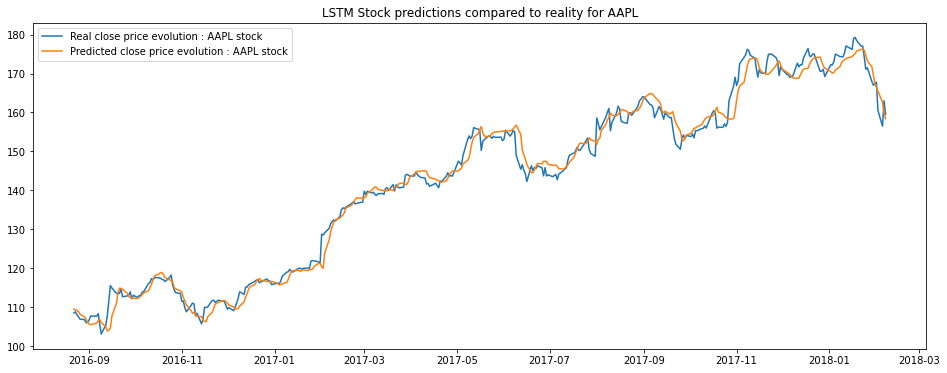

In [16]:
#Plot results
plt.figure(figsize=(16, 6))
plt.plot(dates_test, close_price_real, label='Real close price evolution : ' + selected_name + ' stock')
plt.plot(dates_test, close_price_predicted, label='Predicted close price evolution : ' + selected_name  + ' stock')
plt.legend()
plt.title("LSTM Stock predictions compared to reality for " + selected_name)
plt.show()

You can try to improve your model by adding as features the information of other actions. As you know, in stock market, most of the information that impacts it is out of the stock market information itself.